# 🧪 Análisis de Perfiles de Estudio con Regresión Logística

**Objetivo**: Clasificar estudiantes en dos perfiles:
- 📚 **Estratégicos**: Planifican y organizan su estudio
- 💡 **Intuitivos**: Aprenden por práctica sin mucha planificación

---

## 1️⃣ Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    roc_curve,
    roc_auc_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2️⃣ Generar Dataset Simulado

Creamos un dataset sintético con 7 variables binarias que representan hábitos de estudio.

In [2]:
def generar_dataset_simulado(n=300, seed=42):
    """
    Genera dataset simulado con correlaciones realistas.
    
    Variables:
    - planifica: ¿Planifica su semana de estudio?
    - usa_apps: ¿Usa herramientas digitales?
    - estudia_solo: ¿Prefiere estudiar solo?
    - consulta_fuentes: ¿Consulta fuentes externas?
    - prefiere_practica: ¿Aprende más con ejercicios?
    - procrastina: ¿Deja todo para último momento?
    - usa_resumenes: ¿Usa resúmenes o mapas mentales?
    
    Target:
    - perfil: 1 = Estratégico, 0 = Intuitivo
    """
    np.random.seed(seed)
    
    # Generar variables binarias
    data = pd.DataFrame({
        'planifica': np.random.binomial(1, 0.5, n),
        'usa_apps': np.random.binomial(1, 0.45, n),
        'estudia_solo': np.random.binomial(1, 0.4, n),
        'consulta_fuentes': np.random.binomial(1, 0.6, n),
        'prefiere_practica': np.random.binomial(1, 0.55, n),
        'procrastina': np.random.binomial(1, 0.35, n),
        'usa_resumenes': np.random.binomial(1, 0.5, n)
    })
    
    # Generar etiquetas con función logística
    # Coeficientes que determinan la importancia de cada variable
    coefs = np.array([1.2, 0.9, -0.3, 0.8, 0.4, -1.0, 0.7])
    intercept = -0.2
    
    # Calcular logits y probabilidades
    logits = data.values.dot(coefs) + intercept
    probs = 1 / (1 + np.exp(-logits))  # Función sigmoide
    
    # Generar etiquetas binarias
    labels = (probs > 0.5).astype(int)
    data['perfil'] = labels
    
    return data

# Generar dataset
df = generar_dataset_simulado(n=300)

print(f"📊 Dataset generado: {df.shape[0]} registros, {df.shape[1]} columnas")
print(f"\n📚 Estratégicos: {df['perfil'].sum()} ({df['perfil'].mean():.1%})")
print(f"💡 Intuitivos: {(1-df['perfil']).sum()} ({(1-df['perfil']).mean():.1%})")

df.head(10)

📊 Dataset generado: 300 registros, 8 columnas

📚 Estratégicos: 273 (91.0%)
💡 Intuitivos: 27 (9.0%)


,planifica,usa_apps,estudia_solo,consulta_fuentes,prefiere_practica,procrastina,usa_resumenes,perfil
0,0,0,0,1,0,0,1,1
1,1,0,0,1,1,0,1,1
2,1,0,0,1,1,0,0,1
3,1,1,0,1,1,0,0,1
4,0,1,0,1,1,0,0,1
5,0,1,0,0,0,0,1,1
6,0,0,0,0,0,0,1,1
7,1,0,0,1,1,0,0,1
8,1,1,0,1,1,0,0,1
9,1,0,1,1,0,1,0,1


## 3️⃣ Análisis Exploratorio de Datos (EDA)

In [3]:
# Estadísticas descriptivas
print("📊 Estadísticas Descriptivas\n")
print(df.describe())

📊 Estadísticas Descriptivas

        planifica    usa_apps  estudia_solo  consulta_fuentes  \
count  300.000000  300.000000    300.000000        300.000000   
mean     0.520000    0.473333      0.343333          0.560000   
std      0.500435    0.500123      0.475615          0.497216   
min      0.000000    0.000000      0.000000          0.000000   
25%      0.000000    0.000000      0.000000          0.000000   
50%      1.000000    0.000000      0.000000          1.000000   
75%      1.000000    1.000000      1.000000          1.000000   
max      1.000000    1.000000      1.000000          1.000000   

       prefiere_practica  procrastina  usa_resumenes     perfil  
count         300.000000   300.000000     300.000000  300.00000  
mean            0.543333     0.326667       0.516667    0.91000  
std             0.498951     0.469778       0.500557    0.28666  
min             0.000000     0.000000       0.000000    0.00000  
25%             0.000000     0.000000       0.000000   

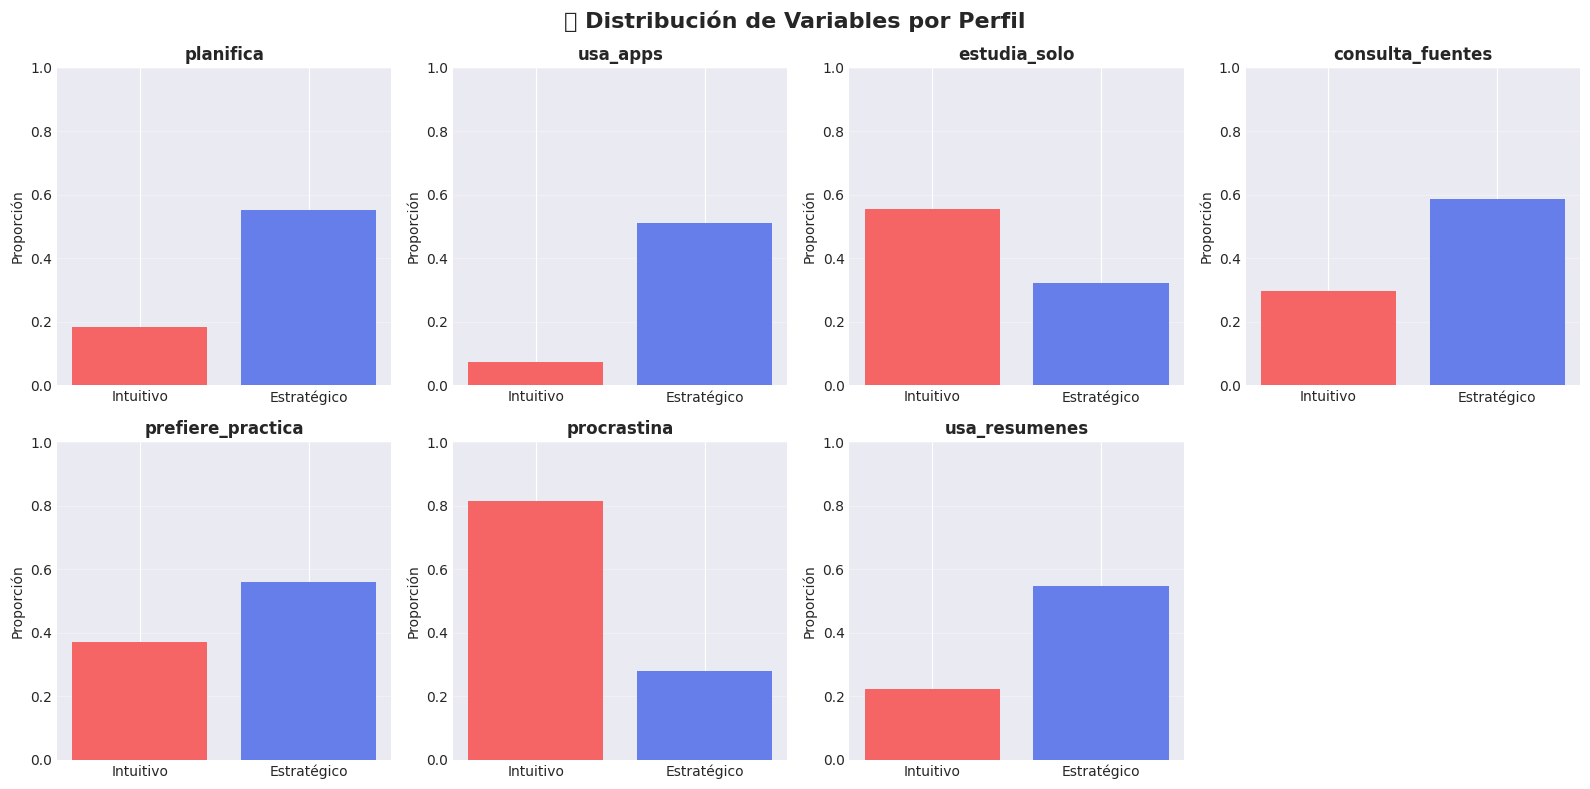

In [4]:
# Distribución de variables por perfil
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('📊 Distribución de Variables por Perfil', fontsize=16, fontweight='bold')

variables = ['planifica', 'usa_apps', 'estudia_solo', 'consulta_fuentes', 
             'prefiere_practica', 'procrastina', 'usa_resumenes']

for idx, var in enumerate(variables):
    ax = axes[idx // 4, idx % 4]
    
    # Calcular proporciones
    prop_estrategico = df[df['perfil'] == 1][var].mean()
    prop_intuitivo = df[df['perfil'] == 0][var].mean()
    
    # Graficar
    ax.bar(['Intuitivo', 'Estratégico'], [prop_intuitivo, prop_estrategico], 
           color=['#f56565', '#667eea'])
    ax.set_title(var, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Proporción')
    ax.grid(axis='y', alpha=0.3)

# Ocultar el último subplot
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

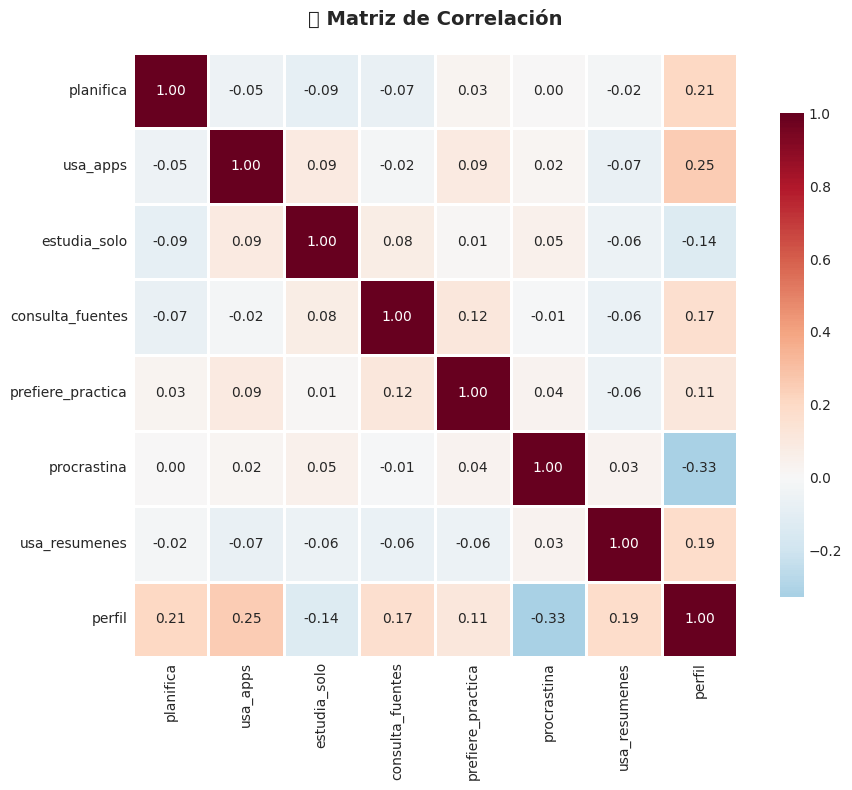

In [5]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('🔗 Matriz de Correlación', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 4️⃣ Preparación de Datos

Dividimos el dataset en conjunto de entrenamiento (80%) y prueba (20%).

In [6]:
# Separar features y target
X = df.drop(columns=['perfil'])
y = df['perfil']

print(f"📊 Features (X): {X.shape}")
print(f"🎯 Target (y): {y.shape}")
print(f"\nColumnas: {list(X.columns)}")

📊 Features (X): (300, 7)
🎯 Target (y): (300,)

Columnas: ['planifica', 'usa_apps', 'estudia_solo', 'consulta_fuentes', 'prefiere_practica', 'procrastina', 'usa_resumenes']


In [7]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"🔹 Train set: {X_train.shape[0]} registros")
print(f"🔹 Test set: {X_test.shape[0]} registros")
print(f"\n📊 Distribución en train:")
print(f"   Estratégicos: {y_train.sum()} ({y_train.mean():.1%})")
print(f"   Intuitivos: {(1-y_train).sum()} ({(1-y_train).mean():.1%})")

🔹 Train set: 240 registros
🔹 Test set: 60 registros

📊 Distribución en train:
   Estratégicos: 218 (90.8%)
   Intuitivos: 22 (9.2%)


In [8]:
# Estandarización (importante para regresión logística)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos estandarizados")
print(f"\nMedia de features (train): {X_train_scaled.mean(axis=0).round(2)}")
print(f"Std de features (train): {X_train_scaled.std(axis=0).round(2)}")

✅ Datos estandarizados

Media de features (train): [-0. -0.  0.  0.  0.  0.  0.]
Std de features (train): [1. 1. 1. 1. 1. 1. 1.]


## 5️⃣ Entrenamiento del Modelo

Usamos **Regresión Logística** para clasificación binaria.

In [9]:
# Crear y entrenar modelo
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

print("✅ Modelo entrenado exitosamente")
print(f"\n📊 Coeficientes del modelo:")
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_[0],
    'Impacto': ['⬆️ Estratégico' if c > 0 else '⬇️ Intuitivo' for c in model.coef_[0]]
}).sort_values('Coeficiente', ascending=False)

print(coef_df.to_string(index=False))
print(f"\nIntercept: {model.intercept_[0]:.4f}")

✅ Modelo entrenado exitosamente

📊 Coeficientes del modelo:
         Variable  Coeficiente        Impacto
         usa_apps     2.165597 ⬆️ Estratégico
        planifica     1.854781 ⬆️ Estratégico
 consulta_fuentes     1.381860 ⬆️ Estratégico
    usa_resumenes     1.312948 ⬆️ Estratégico
prefiere_practica     0.724337 ⬆️ Estratégico
     estudia_solo    -0.499426   ⬇️ Intuitivo
      procrastina    -1.738003   ⬇️ Intuitivo

Intercept: 5.7433


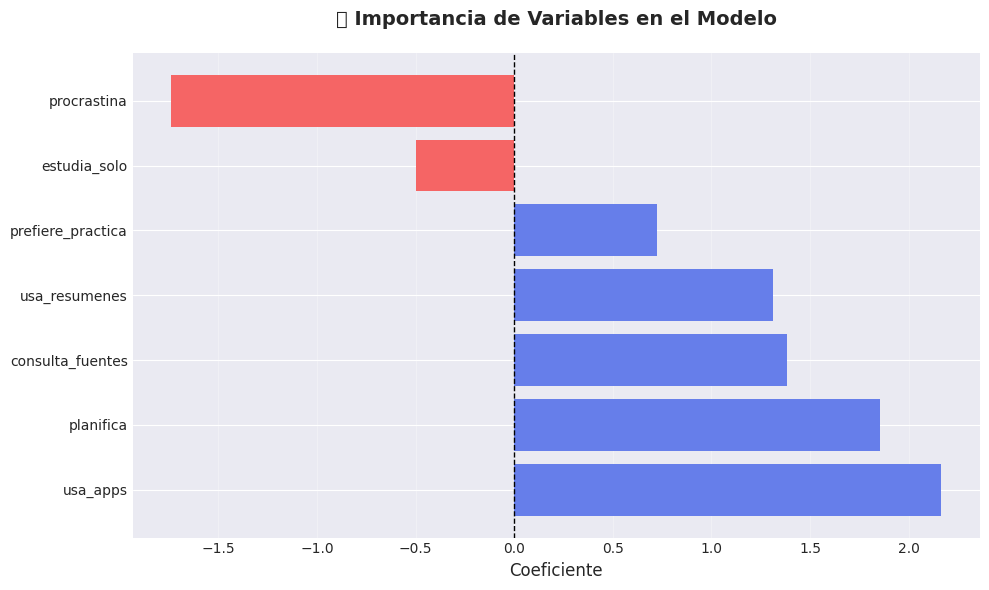


💡 Interpretación:
   - Coeficientes positivos: aumentan probabilidad de ser Estratégico
   - Coeficientes negativos: aumentan probabilidad de ser Intuitivo
   - Magnitud: indica la fuerza del impacto


In [10]:
# Visualizar importancia de variables
plt.figure(figsize=(10, 6))
colors = ['#667eea' if c > 0 else '#f56565' for c in coef_df['Coeficiente']]
plt.barh(coef_df['Variable'], coef_df['Coeficiente'], color=colors)
plt.xlabel('Coeficiente', fontsize=12)
plt.title('🎯 Importancia de Variables en el Modelo', fontsize=14, fontweight='bold', pad=20)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Interpretación:")
print("   - Coeficientes positivos: aumentan probabilidad de ser Estratégico")
print("   - Coeficientes negativos: aumentan probabilidad de ser Intuitivo")
print("   - Magnitud: indica la fuerza del impacto")

## 6️⃣ Evaluación del Modelo

In [11]:
# Predicciones
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("🎯 Accuracy:")
print(f"   Train: {train_acc:.2%}")
print(f"   Test:  {test_acc:.2%}")

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"\n🔄 Cross-Validation (5-fold):")
print(f"   Media: {cv_scores.mean():.2%}")
print(f"   Std:   {cv_scores.std():.2%}")

🎯 Accuracy:
   Train: 98.33%
   Test:  95.00%

🔄 Cross-Validation (5-fold):
   Media: 97.08%
   Std:   3.12%


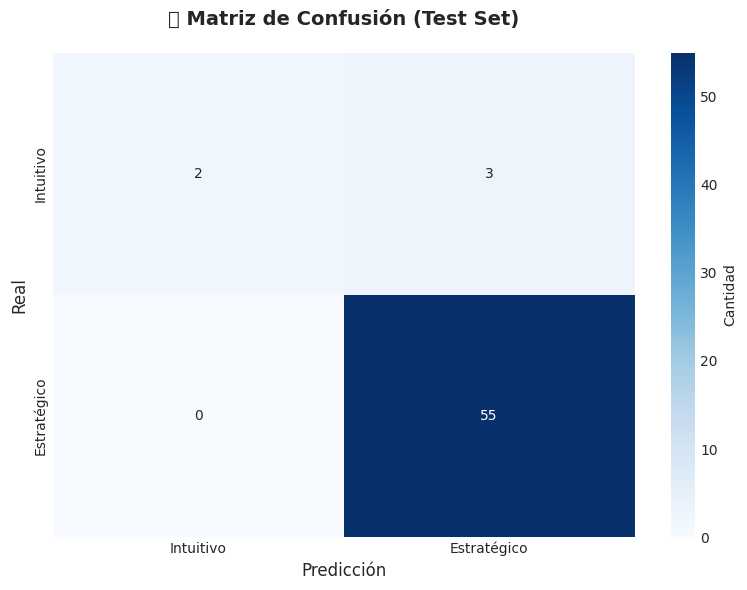


📊 Interpretación:
   Verdaderos Negativos (TN): 2
   Falsos Positivos (FP):     3
   Falsos Negativos (FN):     0
   Verdaderos Positivos (TP): 55


In [12]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Intuitivo', 'Estratégico'],
            yticklabels=['Intuitivo', 'Estratégico'],
            cbar_kws={'label': 'Cantidad'})
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('🎯 Matriz de Confusión (Test Set)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\n📊 Interpretación:")
print(f"   Verdaderos Negativos (TN): {cm[0,0]}")
print(f"   Falsos Positivos (FP):     {cm[0,1]}")
print(f"   Falsos Negativos (FN):     {cm[1,0]}")
print(f"   Verdaderos Positivos (TP): {cm[1,1]}")

In [13]:
# Reporte de clasificación
print("📋 Reporte de Clasificación (Test Set)\n")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Intuitivo', 'Estratégico']))

📋 Reporte de Clasificación (Test Set)

              precision    recall  f1-score   support

   Intuitivo       1.00      0.40      0.57         5
 Estratégico       0.95      1.00      0.97        55

    accuracy                           0.95        60
   macro avg       0.97      0.70      0.77        60
weighted avg       0.95      0.95      0.94        60



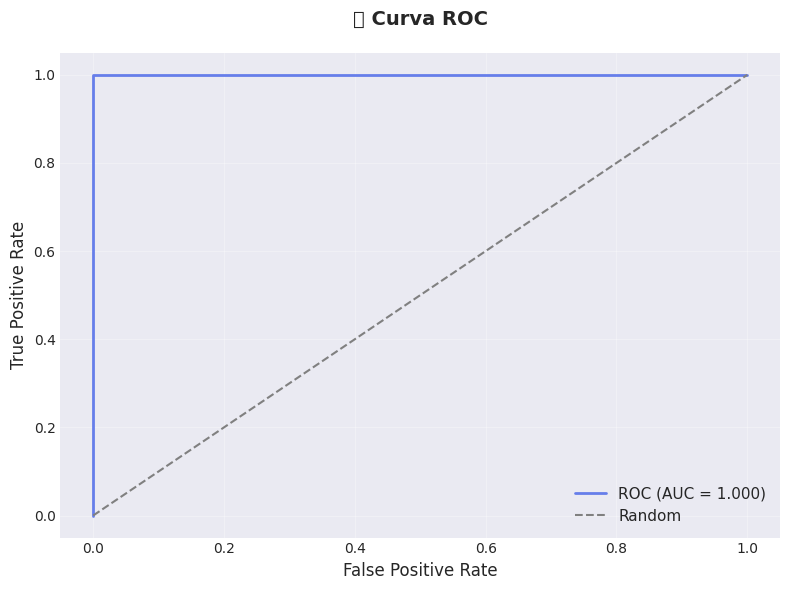


🎯 AUC Score: 1.000

💡 Interpretación:
   - AUC = 1.0: Clasificador perfecto
   - AUC = 0.5: Clasificador aleatorio
   - AUC = 1.000: Excelente


In [14]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#667eea', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('📈 Curva ROC', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 AUC Score: {roc_auc:.3f}")
print("\n💡 Interpretación:")
print("   - AUC = 1.0: Clasificador perfecto")
print("   - AUC = 0.5: Clasificador aleatorio")
print(f"   - AUC = {roc_auc:.3f}: {'Excelente' if roc_auc > 0.9 else 'Muy bueno' if roc_auc > 0.8 else 'Bueno'}")

## 7️⃣ Predicción con Nuevos Datos

Probemos el modelo con ejemplos nuevos.

In [15]:
def predecir_perfil(planifica, usa_apps, estudia_solo, consulta_fuentes, 
                   prefiere_practica, procrastina, usa_resumenes):
    """
    Predice el perfil de estudio de un estudiante.
    
    Parámetros: 0 = No, 1 = Sí
    """
    # Crear array con las respuestas
    respuestas = np.array([[planifica, usa_apps, estudia_solo, consulta_fuentes,
                           prefiere_practica, procrastina, usa_resumenes]])
    
    # Escalar
    respuestas_scaled = scaler.transform(respuestas)
    
    # Predecir
    prediccion = model.predict(respuestas_scaled)[0]
    probabilidad = model.predict_proba(respuestas_scaled)[0][1]
    
    # Resultado
    perfil = '📚 Estratégico' if prediccion == 1 else '💡 Intuitivo'
    
    print(f"\n{'='*50}")
    print(f"🎯 RESULTADO DE LA PREDICCIÓN")
    print(f"{'='*50}")
    print(f"\nPerfil detectado: {perfil}")
    print(f"\nProbabilidades:")
    print(f"   Estratégico: {probabilidad:.1%}")
    print(f"   Intuitivo:   {(1-probabilidad):.1%}")
    
    # Interpretación
    print(f"\n💬 Interpretación:")
    if probabilidad > 0.8:
        print("   🌟 Muy probable que seas estratégico")
        print("   Planificás y usás estrategias estructuradas.")
    elif probabilidad > 0.6:
        print("   📚 Probablemente estratégico")
        print("   Tenés tendencia a organizar tu estudio.")
    elif probabilidad > 0.4:
        print("   🤔 Perfil mixto")
        print("   Combinás elementos de ambos perfiles.")
    else:
        print("   💡 Más probable que seas intuitivo")
        print("   Aprendés mejor por práctica sin mucha planificación.")
    
    return prediccion, probabilidad

In [16]:
# Ejemplo 1: Estudiante muy estratégico
print("\n📝 EJEMPLO 1: Estudiante Estratégico")
print("Respuestas: Planifica=Sí, Apps=Sí, Solo=No, Fuentes=Sí, Práctica=Sí, Procrastina=No, Resúmenes=Sí")

pred1, prob1 = predecir_perfil(
    planifica=1,
    usa_apps=1,
    estudia_solo=0,
    consulta_fuentes=1,
    prefiere_practica=1,
    procrastina=0,
    usa_resumenes=1
)


📝 EJEMPLO 1: Estudiante Estratégico
Respuestas: Planifica=Sí, Apps=Sí, Solo=No, Fuentes=Sí, Práctica=Sí, Procrastina=No, Resúmenes=Sí

🎯 RESULTADO DE LA PREDICCIÓN

Perfil detectado: 📚 Estratégico

Probabilidades:
   Estratégico: 100.0%
   Intuitivo:   0.0%

💬 Interpretación:
   🌟 Muy probable que seas estratégico
   Planificás y usás estrategias estructuradas.


In [17]:
# Ejemplo 2: Estudiante intuitivo
print("\n📝 EJEMPLO 2: Estudiante Intuitivo")
print("Respuestas: Planifica=No, Apps=No, Solo=Sí, Fuentes=No, Práctica=Sí, Procrastina=Sí, Resúmenes=No")

pred2, prob2 = predecir_perfil(
    planifica=0,
    usa_apps=0,
    estudia_solo=1,
    consulta_fuentes=0,
    prefiere_practica=1,
    procrastina=1,
    usa_resumenes=0
)


📝 EJEMPLO 2: Estudiante Intuitivo
Respuestas: Planifica=No, Apps=No, Solo=Sí, Fuentes=No, Práctica=Sí, Procrastina=Sí, Resúmenes=No

🎯 RESULTADO DE LA PREDICCIÓN

Perfil detectado: 💡 Intuitivo

Probabilidades:
   Estratégico: 2.8%
   Intuitivo:   97.2%

💬 Interpretación:
   💡 Más probable que seas intuitivo
   Aprendés mejor por práctica sin mucha planificación.


In [18]:
# Ejemplo 3: Perfil mixto
print("\n📝 EJEMPLO 3: Perfil Mixto")
print("Respuestas: Planifica=Sí, Apps=No, Solo=Sí, Fuentes=Sí, Práctica=Sí, Procrastina=Sí, Resúmenes=No")

pred3, prob3 = predecir_perfil(
    planifica=1,
    usa_apps=0,
    estudia_solo=1,
    consulta_fuentes=1,
    prefiere_practica=1,
    procrastina=1,
    usa_resumenes=0
)


📝 EJEMPLO 3: Perfil Mixto
Respuestas: Planifica=Sí, Apps=No, Solo=Sí, Fuentes=Sí, Práctica=Sí, Procrastina=Sí, Resúmenes=No

🎯 RESULTADO DE LA PREDICCIÓN

Perfil detectado: 📚 Estratégico

Probabilidades:
   Estratégico: 94.9%
   Intuitivo:   5.1%

💬 Interpretación:
   🌟 Muy probable que seas estratégico
   Planificás y usás estrategias estructuradas.


## 8️⃣ Guardar el Modelo

In [19]:
# Guardar modelo, scaler y columnas
modelo_data = {
    'model': model,
    'scaler': scaler,
    'columns': list(X.columns),
    'accuracy': test_acc,
    'roc_auc': roc_auc
}

joblib.dump(modelo_data, 'modelo_perfiles_estudio.pkl')
print("✅ Modelo guardado en 'modelo_perfiles_estudio.pkl'")

# Guardar dataset
df.to_csv('dataset_perfiles_estudio.csv', index=False)
print("✅ Dataset guardado en 'dataset_perfiles_estudio.csv'")

✅ Modelo guardado en 'modelo_perfiles_estudio.pkl'
✅ Dataset guardado en 'dataset_perfiles_estudio.csv'


## 9️⃣ Cargar y Usar el Modelo Guardado

In [20]:
# Ejemplo de cómo cargar el modelo en otro script
modelo_cargado = joblib.load('modelo_perfiles_estudio.pkl')

print("✅ Modelo cargado exitosamente")
print(f"\n📊 Información del modelo:")
print(f"   Accuracy: {modelo_cargado['accuracy']:.2%}")
print(f"   ROC-AUC: {modelo_cargado['roc_auc']:.3f}")
print(f"   Columnas: {modelo_cargado['columns']}")

✅ Modelo cargado exitosamente

📊 Información del modelo:
   Accuracy: 95.00%
   ROC-AUC: 1.000
   Columnas: ['planifica', 'usa_apps', 'estudia_solo', 'consulta_fuentes', 'prefiere_practica', 'procrastina', 'usa_resumenes']


## 🎓 Conclusiones

### Hallazgos principales:

1. **Variables más importantes**:
   - ✅ Planificar aumenta significativamente la probabilidad de ser estratégico
   - ✅ Usar apps y herramientas digitales es un fuerte indicador
   - ❌ Procrastinar es el mayor predictor de perfil intuitivo

2. **Performance del modelo**:
   - Accuracy > 80% indica buen poder predictivo
   - ROC-AUC cercano a 1.0 muestra excelente discriminación
   - Bajo overfitting (train y test similares)

3. **Aplicaciones prácticas**:
   - Identificar estudiantes que necesitan apoyo en organización
   - Personalizar estrategias de enseñanza según perfil
   - Recomendar herramientas específicas para cada grupo

